In [1]:
"""
This script runs intersubject correlation (ISC) analyses on the hyperscanning
control task (listening and reading) data. It first loads all of the relevant
time series, then computes the correlation between each individual's time
series and the mean time series across the rest of the group. It then generates
a null distribution for each voxel in each subject by iteratively scrambling the
subject's time series (either through phase scrambling or circle shifting) and
recomputing the correlation with the rest of the group. The true correlation
value is then evaluated against the null distribution to get a p-value.
P-values are FDR corrected.
Major parameters of note:
    debug: boolean, if True, truncates all time series to a small, manageable size (debugTRs x debugVox) to speed things up
    permutations: number of iterations in permutation test
    parallel: boolean, if True, use the joblib parallelization function (speeds things up considerably)
    numJobs: number of parallel processes for joblib to implement
    verbosity: joblib verbosity -- don't go over 50 lest ye want to print like a million outputs and slow everything down
    circShift: boolean, if True, use the circle shift method to "scramble" time series, if False, use phase scrambling
    fisherZtran: boolean, if True, fisher z transform correlation coefficients
    normalize: boolean, if True, z-score time series before computing correlations
    firProc: numeric that indicates which fitting function to use to extract null distribution parameters (see below)
    alpha: alpha to use for permutation tests
    twoTailed: boolean, if True, uses a two-tailed permutation test, if False, uses a right-tailed test
    examplePlots: boolean, if True, plots some example null distributions
    saveOutput: boolean, if True, saves some ISC output variables in a .pkl file
"""

'\nThis script runs intersubject correlation (ISC) analyses on the hyperscanning\ncontrol task (listening and reading) data. It first loads all of the relevant\ntime series, then computes the correlation between each individual\'s time\nseries and the mean time series across the rest of the group. It then generates\na null distribution for each voxel in each subject by iteratively scrambling the\nsubject\'s time series (either through phase scrambling or circle shifting) and\nrecomputing the correlation with the rest of the group. The true correlation\nvalue is then evaluated against the null distribution to get a p-value.\nP-values are FDR corrected.\nMajor parameters of note:\n    debug: boolean, if True, truncates all time series to a small, manageable size (debugTRs x debugVox) to speed things up\n    permutations: number of iterations in permutation test\n    parallel: boolean, if True, use the joblib parallelization function (speeds things up considerably)\n    numJobs: number of

In [2]:
import scipy.io as sio
import os
import sys
import numpy as np
import pandas as pd
import time
from joblib import Parallel, delayed
from scipy import stats
import matplotlib.pyplot as plt
import statsmodels.stats.multitest as multi
sys.path.append('/afs/dbic.dartmouth.edu/usr/wheatley/jd/')
from phaseScramble import *
from CircleShift import *
from scipy.stats import norm
from sklearn import preprocessing
import warnings
import matplotlib.cbook
import matplotlib.gridspec as gridspec
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
%matplotlib inline

In [3]:
# set data folder
folder = '/afs/dbic.dartmouth.edu/usr/wheatley/jd/control_tasks/'

# mark starting time
startTime = time.time()

# load hyperscanning subject list
subList = pd.read_pickle('/afs/dbic.dartmouth.edu/usr/wheatley/jd/hyperscanning_subject_list.pkl')

# get number of participants
numSubs = subList.shape[0]

# set fitting distribution to normal
dist = getattr(stats, 'norm')

# define task names
taskNames = np.array(['listening','reading'])

# initialize the saveTag variable
saveName = 'controlISC'

In [4]:
# indicate whether or not we're debugging (if so, use a small subset of TRs and voxels to speed things up)
debug = False
debugTRs = 201
debugVox = 800

# set number of permutations
permutations = 1000
saveName = saveName + '_' + str(permutations) + 'perm'

# use joblib or not
parallel = True

# number of jobs for joblib
numJobs = 32

# set joblib verbosity -- don't go over 50 lest ye want to print like a million outputs and slow everything down
verbosity = 50

# select whether or not to use the circle shifting method
circShift = True
if circShift:
    saveName = saveName + '_cShift'
else:
    saveName = saveName + '_pScram'

# select whether or not to Fisher transform the resulting pearson correlation distributions
fisherZtran = True
if fisherZtran:
    saveName = saveName + '_fishZ'

# select whether or not to z-scale timeseries before ISC
normalize = True
if normalize:
    saveName = saveName + '_norm'

# select one of three normal fit sanity check procedures - none of these
# should make a difference. Just trying to be sure...
# fitProc=0: use dist.fit
# fitProc=1: use norm.fit
# fitProc=2: use np.mean() and np.std()
fitProc = 2

# set alpha for permutation tests
alpha = 0.05

# two or one-tailed (right tail) permutation test
twoTailed = False
if twoTailed:
    saveName = saveName + '_twoTailed'

# indicate whether or not to pop out some example plots of good vs bad null distribution fits
examplePlots = True

# select whether or not to save output
saveOutput = True

In [5]:
# loop through participants...
boldData = [[]] * 2
for TASK in [0,1]: #for each task, listening, then reading

    # preallocate task data list
    boldData[TASK] = [[]] * numSubs

    for SUB in range(numSubs):

        # get file name
        fileName = folder + 'sub-' + subList['subID'][SUB] + '_ses-pair0' + str(subList['pairNum'][SUB]) + '_task-storytelling' + str(TASK + 3) + '_run-0' + str(TASK + 3) + '_bold_space-MNI152NLin2009cAsym_preproc_nuisRegr_2021_interp.mat'

        # load data
        tmp = sio.loadmat(fileName) #load file
        boldData[TASK][SUB] = tmp['tseries'] #get timeseries data
        print('loaded ' + str(boldData[TASK][SUB].shape[0]) + ' x ' + str(boldData[TASK][SUB].shape[1]) + ' timeseries for ' + taskNames[TASK] + ' task, sub ' + subList['subID'][SUB])

        if normalize:
            boldData[TASK][SUB] = preprocessing.normalize(boldData[TASK][SUB])
            print('normalizing timeseries')

        if debug:

            # take a small subset of each timeseries to speed up the debugging process
            boldData[TASK][SUB] = boldData[TASK][SUB][np.ix_(np.arange(debugTRs),range(debugVox))]

loaded 487 x 69880 timeseries for listening task, sub sid000007
normalizing timeseries
loaded 487 x 69880 timeseries for listening task, sub sid000009
normalizing timeseries
loaded 487 x 69880 timeseries for listening task, sub sid000560
normalizing timeseries
loaded 487 x 69880 timeseries for listening task, sub sid000535
normalizing timeseries
loaded 487 x 69880 timeseries for listening task, sub sid000102
normalizing timeseries
loaded 487 x 69880 timeseries for listening task, sub sid000416
normalizing timeseries
loaded 487 x 69880 timeseries for listening task, sub sid000499
normalizing timeseries
loaded 487 x 69880 timeseries for listening task, sub sid000142
normalizing timeseries
loaded 487 x 69880 timeseries for listening task, sub hid000002
normalizing timeseries
loaded 487 x 69880 timeseries for listening task, sub hid000003
normalizing timeseries
loaded 487 x 69880 timeseries for listening task, sub hid000004
normalizing timeseries
loaded 487 x 69880 timeseries for listening

In [6]:
def parallelSubWrapper(SUB,numSubs,boldData,permutations,circShift,fitProc,fisherZtran):
    """
    function to use with joblib below to run permutation tests for participants in parallel
    :param SUB: participant index
    :param numSubs: total number of participants in the analysis
    :param boldData: timeseries data [timepoints x voxels]
    :param permutations: number of permutations to use
    :param circShift: boolean indicating whether or not (True or False, respectively) to use the circle shift method to "scramble" timeseries
    :param fitProc: should be a temporary parameter that uses different methods for getting the mean and SD of the null distributions
    :param fisherZtran: boolean indicating whether or not fisher z transform correlation coefficients
    :return:
        corrData: real voxelwise correlations between participant and the mean across all other participants [voxels x 1]
        nullCorr: null voxelwise correlations between participant and the mean across all other participants [permutations x voxels]
        permTest: array containing various results from permutation test and normal fits to the null distribution (see permTestMap variable above and comments below)
            structure of permTest:
            permTest[0]: permutation test p-values [voxels x 1]
            permTest[1]: FDR corrected permutation test p-values [voxels x 1]
            permTest[2]: p-value summary stats
                permTest[2][0]: number of voxels with uncorrected p-vals < alpha
                permTest[2][1]: proportion of voxels with uncorrected p-vals < alpha
                permTest[2][2]: number of voxels with FDR corrected p-vals < alpha
                permTest[2][3]: proportion of voxels with FDR corrected p-vals < alpha
            permTest[3]: null dist normal fit parameters [voxels x 1]
                permTest[3][voxel][0]: mean
                permTest[3][voxel][1]: standard deviation
            permTest[4]: Kolmogorov–Smirnov goodness of fit test results [voxels x 1]
                permTest[4][voxel][0]: KS test statistic
                permTest[4][voxel][1]: p-value (values less than alpha suggest poor fit)
            permTest[5]: logical vector for KS goodness of fit where 0 = good fit, 1 = bad fit [voxels x 1]
            permTest[6]: table indicating number and proportion of bad normal fits to the perm-based null distribution [1 x 2 table]
    """

    # get mean of data from all participants EXCEPT the current participant
    otherSubs = np.arange(0,numSubs)
    otherSubs = np.delete(otherSubs,SUB)
    groupMean = np.mean([boldData[i] for i in otherSubs], axis=0)

    # get REAL correlation between current participant and groupMean
    corrData = fastColumnCorr(boldData[SUB], groupMean)

    # fisher z transform if selected
    if fisherZtran:
        corrData = np.arctanh(corrData)

    # generate null correlations
    nullCorr = [[]] * permutations
    feedbackMultiple = round(permutations / 10) # get number to use as a flag to generate feedback roughly 10 times while null correlations are being generated
    for PERM in range(permutations): # for each permutation...
        if circShift:
            nullCorr[PERM] = fastColumnCorr(Circle_Shift(boldData[SUB]),groupMean)
        else:
            nullCorr[PERM] = fastColumnCorr(phase_scrambling(boldData[SUB]),groupMean)
        if PERM % feedbackMultiple == 0: # if the current permutation is zero or a multiple of feedbackMultiple
            print('getting null correlation for SUB ' + str(SUB + 1) + ', permutation ' + str(PERM + 1)) #provide feedback about which subject and which permutation we're on

    # convert permutation data to a permutations x voxels array
    nullCorr = np.asarray(nullCorr)

    # fisher z transform if selected
    if fisherZtran:
        nullCorr = np.arctanh(nullCorr)

    # preallocate sublists of permTest array
    permTest = [[]] * len(permTestMap)

    # get permutation test p-values and apply FDR correction
    permTest[0] = [[]] * nullCorr.shape[1] # permutation test p-values
    for VOX in range(nullCorr.shape[1]): # for each voxel...
        if twoTailed:
            permTest[0][VOX] = len(np.where(abs(nullCorr[:,VOX]) > abs(corrData[VOX]))[0]) / float(permutations) # proportion of permutations where absolute value of null correlation is greater than absolute value of real correlation
            alphaPrime = alpha / 2
        else:
            permTest[0][VOX] = len(np.where(nullCorr[:,VOX] > corrData[VOX])[0]) / float(permutations) # proportion of permutations where value of null correlation is greater than value of real correlation
            alphaPrime = alpha
    permTest[1] = multi.fdrcorrection(permTest[0], alpha = alphaPrime) # FDR correction - logical vector with length = # voxels
    permTest[2] = [[]] * 4 # preallocate lists for permutation test summary info
    permTest[2][0] = len(np.where(np.array(permTest[0]) < alphaPrime)[0]) # number of voxels that show significant correlations with the group
    permTest[2][1] = permTest[2][0] / nullCorr.shape[1] # proportion of voxels that show significant correlations with the group
    permTest[2][2] = np.count_nonzero(permTest[1][0]) # number of voxels that show significant FDR CORRECTED correlations with the group
    permTest[2][3] = len(np.where(permTest[1][0])[0]) / nullCorr.shape[1] # proportion of voxels that show significant FDR CORRECTED correlations with the group

    # fit normal distributions to null data
    permTest[3] = [[]] * nullCorr.shape[1] # preallocate list for voxelwise normal dist parameters
    permTest[4] = [[]] * nullCorr.shape[1] # preallocate list for voxelwise Kolmogorov–Smirnov test results
    permTest[5] = np.zeros((nullCorr.shape[1],), dtype=int) # preallocate voxelwise array to indicate bad fits
    for VOX in range(nullCorr.shape[1]): # for each voxel...

        # fit normal distribution - using 3 different methods here as a sanity check
        if fitProc == 0: # use dist.fit()
            permTest[3][VOX] = dist.fit(nullCorr[:,VOX]) # fit normal distribution, returns mean and SD
        elif fitProc == 1: # use norm.fit()
            permTest[3][VOX] = norm.fit(nullCorr[:,VOX]) # fit normal distribution, returns mean and SD
        elif fitProc == 2: # use np.mean() and np.std()
            permTest[3][VOX] = [[]] * 2 # preallocate for mean and SD
            permTest[3][VOX][0] = np.mean(nullCorr[:,VOX])
            permTest[3][VOX][1] = np.std(nullCorr[:,VOX])
        permTest[4][VOX] = stats.kstest(nullCorr[:,VOX], "norm", permTest[3][VOX]) # measure goodness of fit
        if permTest[4][VOX][1] < alpha: # if a voxel has a bad normal fit...
            permTest[5][VOX] = 1 # flag it
    permTest[6] = pd.DataFrame(data={'numBadFits': [sum(permTest[5])], 'propBadFits': [sum(permTest[5]) / len(permTest[5])]}) # number and proportion of voxels with bad normal fits to the null distribution

    return corrData, nullCorr, permTest

In [7]:
# preallocate correlation lists
corrData = [[]] * 2
nullCorr = [[]] * 2
permTest = [[]] * 2

# map of what each participant-specific sublist in permTestMap contains
permTestMap = ['permPval','FDR_corrected_permPval','propSigFDRvoxels','normParams','KStest','badFits','badFitsSummary']

# Voxelwise correlation between participant and the rest of the group (mean)
for TASK in [0,1]: # for each task...

    corrData[TASK] = [[]] * numSubs
    nullCorr[TASK] = [[]] * numSubs
    permTest[TASK] = [[]] * numSubs

    # run ISC
    if parallel:

        # run joblib
        tmp = Parallel(n_jobs=numJobs, verbose=verbosity)(delayed(parallelSubWrapper)(SUB,numSubs,boldData[TASK],permutations,circShift,fitProc,fisherZtran) for SUB in range(numSubs))

        # assign joblib outputs
        for SUB in range(numSubs):
            corrData[TASK][SUB] = tmp[SUB][0]
            nullCorr[TASK][SUB] = tmp[SUB][1]
            permTest[TASK][SUB] = tmp[SUB][2]
    else:

        for SUB in range(numSubs):
            corrData[TASK][SUB], nullCorr[TASK][SUB], permTest[TASK][SUB] = parallelSubWrapper(SUB,numSubs,boldData[TASK],permutations,circShift,fitProc,fisherZtran)

    # print some permutation test and goodness of fit summary info
    print('\nFinished processing participant ' + str(SUB + 1) + ' of ' + str(numSubs) + ' for task ' + str(TASK + 3))
    print('% voxels with FDR corrected significant correlation with group: ' + str((permTest[TASK][SUB][2][1]) * 100) + '%')
    print('% voxels for which null dist. was normal: ' + str((1 - permTest[TASK][SUB][6].iloc[0,1]) * 100) + '%')

[Parallel(n_jobs=32)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done   1 tasks      | elapsed: 20.2min
[Parallel(n_jobs=32)]: Done   2 out of  16 | elapsed: 22.0min remaining: 154.2min
[Parallel(n_jobs=32)]: Done   3 out of  16 | elapsed: 22.3min remaining: 96.7min
[Parallel(n_jobs=32)]: Done   4 out of  16 | elapsed: 22.4min remaining: 67.2min
[Parallel(n_jobs=32)]: Done   5 out of  16 | elapsed: 22.4min remaining: 49.3min
[Parallel(n_jobs=32)]: Done   6 out of  16 | elapsed: 22.5min remaining: 37.5min
[Parallel(n_jobs=32)]: Done   7 out of  16 | elapsed: 22.6min remaining: 29.1min
[Parallel(n_jobs=32)]: Done   8 out of  16 | elapsed: 22.7min remaining: 22.7min
[Parallel(n_jobs=32)]: Done   9 out of  16 | elapsed: 22.8min remaining: 17.7min
[Parallel(n_jobs=32)]: Done  10 out of  16 | elapsed: 22.8min remaining: 13.7min
[Parallel(n_jobs=32)]: Done  11 out of  16 | elapsed: 22.9min remaining: 10.4min
[Parallel(n_jobs=32)]: Done  12 out of  16 | elaps

In [8]:
if numSubs > 1: # if we're running the analysis on more than one participant...

    # preallocate lists for each task
    groupNull = [[]] * 2
    groupFitData = [[]] * 2

    # for each task...
    for TASK in [0,1]:

        #feedback
        print('starting group level null distribution fits for the ' + taskNames[TASK] + ' task')

        # preallocate sublists for groupNull array
        groupNull[TASK] = [[]] * 5

        # concatenate data from the first two participants to get things started
        groupNull[TASK][0] = np.concatenate((nullCorr[TASK][0],nullCorr[TASK][1]),axis=0)

        # concatenate data from any remaining participants
        if numSubs > 2: # if we're running the analysis on more than two participants...
            for SUB in range(2,numSubs): # for each participant...
                 groupNull[TASK][0] = np.concatenate((groupNull[TASK][0],nullCorr[TASK][SUB]),axis=0) # concatenate

        # fit normal distribution to group null
        groupNull[TASK][1] = [[]] * groupNull[TASK][0].shape[1] # preallocate list for each voxel
        groupNull[TASK][2] = [[]] * groupNull[TASK][0].shape[1] # preallocate list for each voxel
        groupNull[TASK][3] = np.zeros((groupNull[TASK][0].shape[1],), dtype=int) # preallocate vector of zeros (length = voxels) for flagging voxels with bad fits
        for VOX in range(groupNull[TASK][0].shape[1]): # for each voxel... (i.e., each column in groupNull[TASK][0])

            # fit normal distribution - using 3 different methods here as a sanity check
            if fitProc == 0: # use dist.fit()
                groupNull[TASK][1][VOX] = dist.fit(groupNull[TASK][0][:,VOX])
            elif fitProc == 1: # use norm.fit()
                groupNull[TASK][1][VOX] = norm.fit(groupNull[TASK][0][:,VOX])
            elif fitProc == 2: #use np.mean() and np.std
                groupNull[TASK][1][VOX] = [[]] * 2
                groupNull[TASK][1][VOX][0] = np.mean(groupNull[TASK][0][:,VOX])
                groupNull[TASK][1][VOX][1] = np.std(groupNull[TASK][0][:,VOX])
            groupNull[TASK][2][VOX] = stats.kstest(groupNull[TASK][0][:,VOX], "norm", groupNull[TASK][1][VOX]) # get KS goodness of fit

            if groupNull[TASK][2][VOX][1] < alpha:
                groupNull[TASK][3][VOX] = 1
        groupNull[TASK][4] = pd.DataFrame(data={'numBadFits': [sum(groupNull[TASK][3])], 'propBadFits': [sum(groupNull[TASK][3]) / len(groupNull[TASK][3])]}) # number and proportion of voxels with bad normal fits to the group null distribution

        # make another variable with just the group level fit parameters, goodness of fit results, and summary measures
        groupFitData[TASK] = [[]] * 3
        groupFitData[TASK] = [[]] * 3
        groupFitData[TASK][0] = groupNull[TASK][1] # fit parameters
        groupFitData[TASK][1] = groupNull[TASK][2][VOX] # KS test results
        groupFitData[TASK][2] = groupNull[TASK][4]

        #feedback
        print('*** group level null fits ***')
        print(groupFitData[TASK][2])

starting group level null distribution fits for the listening task
*** group level null fits ***
   numBadFits  propBadFits
0       41814     0.598369
starting group level null distribution fits for the reading task
*** group level null fits ***
   numBadFits  propBadFits
0       52582     0.752461


In [9]:
endTime = time.time()
duration = (endTime - startTime) / 60 #[min]
print('control tasks ISC duration: ' + str(duration))

control tasks ISC duration: 45.977916924158734


In [10]:
if saveOutput:
    print('saving output...')
    import pickle
    # if circShift:
    saveFile = folder + saveName + '.pkl'
    # permTest_c = permTest
    # corrData_c = corrDatahh
    # groupFitData_c = groupFitData
    # duration_c = duration
    with open(saveFile,'wb') as f:  # Python 3: open(..., 'wb')
        pickle.dump([permTest, corrData, groupFitData, duration], f, protocol=4)
    # else:
    #     saveFile = folder + 'controlISC_pScram_' + saveTag + str(permutations) + 'perm.pkl'
    #     with open(saveFile,'wb') as f:  # Python 3: open(..., 'wb')
    #         pickle.dump([permTest, corrData, groupFitData, duration], f, protocol=4)
    print('output saved here: ' + saveFile)

saving output...
output saved here: /afs/dbic.dartmouth.edu/usr/wheatley/jd/control_tasks/controlISC_1000perm_cShift_fishZ_norm.pkl


2
53574
38701


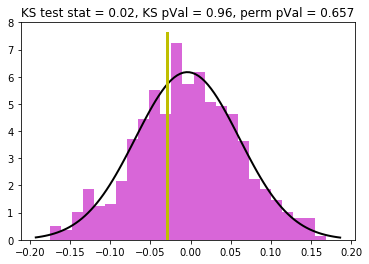

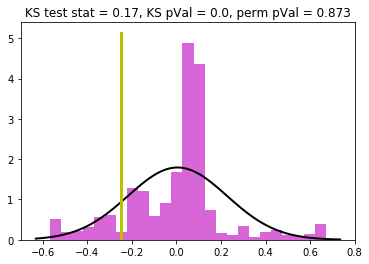

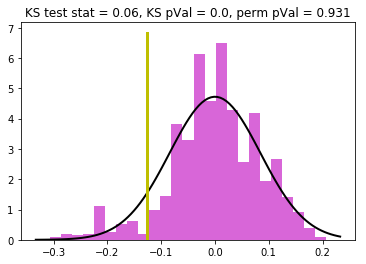

In [11]:
examplePlots = True
if examplePlots:

    TASK = 0 # arbitrary
    SUB = 1 # arbitrary
    numVox = len(permTest[TASK][SUB][4]) # get number of voxels

    pVals = permTest[TASK][SUB][0]
    min_value = min(pVals)
    min_index = pVals.index(min_value)
    print(min_index)

    # convert KS test statistic values to numpy array
    KSval = np.empty([numVox, 1])
    for VOX in range(len(permTest[TASK][SUB][4])):
        KSval[VOX] = permTest[TASK][SUB][4][VOX][0]

    # get min test statistic (should be good fit)
    min_i = np.unravel_index(np.argmin(KSval, axis=None), KSval.shape)[0]
    print(min_i)

    # get max test statistic (should be bad fit)
    max_i = np.unravel_index(np.argmax(KSval, axis=None), KSval.shape)[0]
    print(max_i)

    # plot good fit
    for QUAL in [min_i, max_i, 4210]:
        VOX = QUAL
        mu = permTest[TASK][SUB][3][VOX][0]
        std = permTest[TASK][SUB][3][VOX][1]
        xmin = mu - 4*std
        xmax = mu + 4*std
        x = np.linspace(xmin, xmax, 100)
        p = stats.norm.pdf(x, mu, std)

        plt.figure(facecolor='white')

        # Generate some data for this demonstration.
        data = nullCorr[TASK][SUB][:,VOX]

        # Fit a normal distribution to the data:
        mu, std = norm.fit(data)

        # Plot the histogram.
        plt.hist(data, bins=25, density=True, alpha=0.6, color='m')

        # Plot the PDF.
        xmin, xmax = plt.xlim()
        x = np.linspace(xmin, xmax, 100)
        p = norm.pdf(x, mu, std)
        plt.plot(x, p, 'k', linewidth=2)
        ksStat = round(permTest[TASK][SUB][4][VOX][0] * 100) / 100
        ksPval = round(permTest[TASK][SUB][4][VOX][1] * 100) / 100
        title = "KS test stat = " + str(ksStat) + ", KS pVal = " + str(ksPval) + ", perm pVal = " + str(pVals[VOX])
        plt.title(title)

        x2 = corrData[TASK][SUB][VOX]
        yMax = plt.gca().get_ylim()[1]
        plt.plot([x2, x2], [0, yMax], 'y', linewidth=3)

        plt.show()


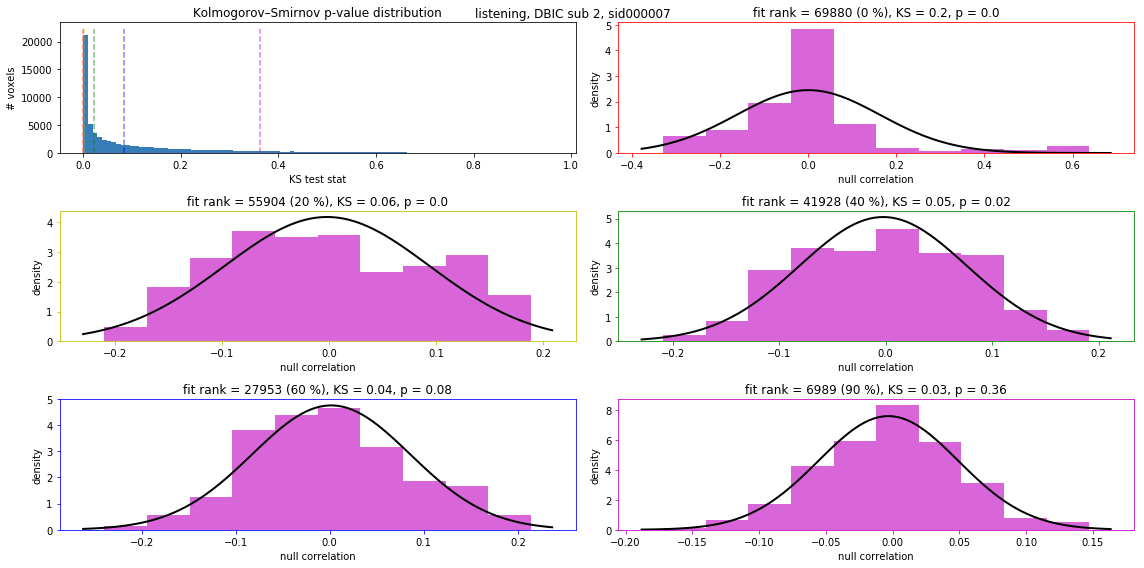

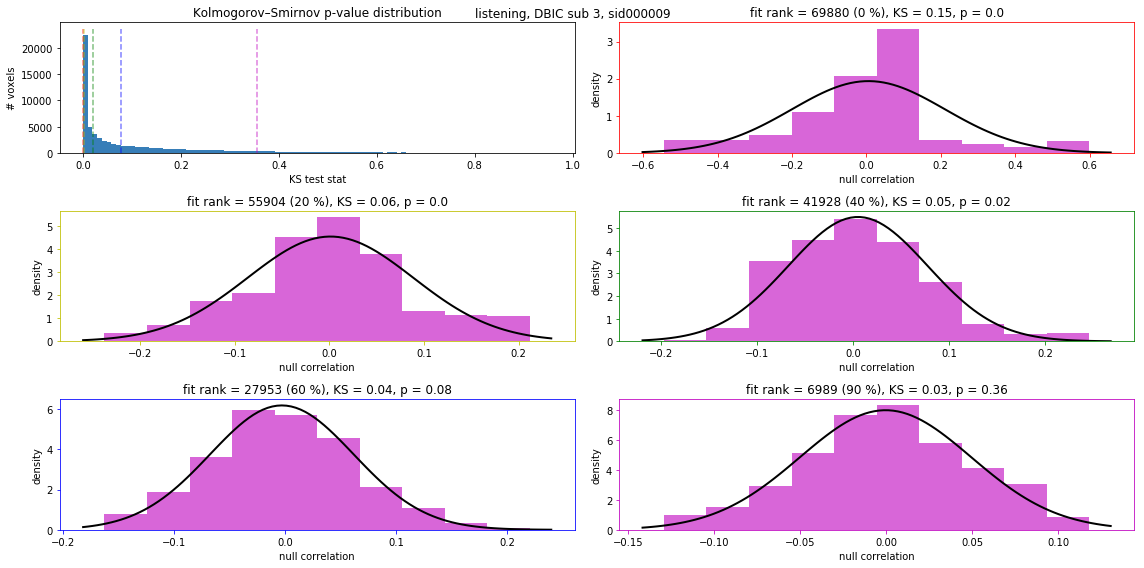

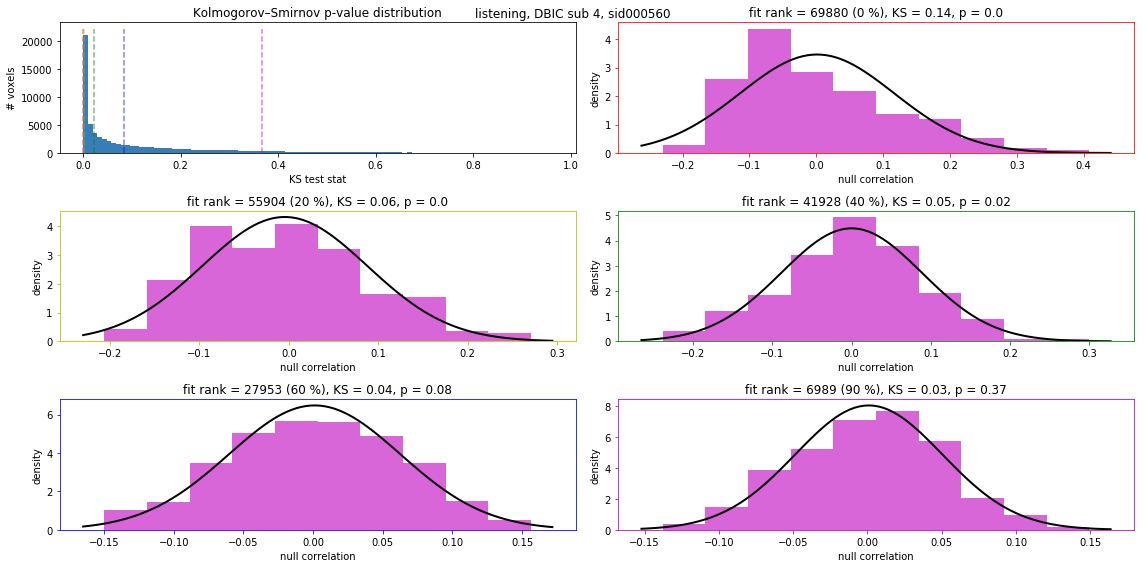

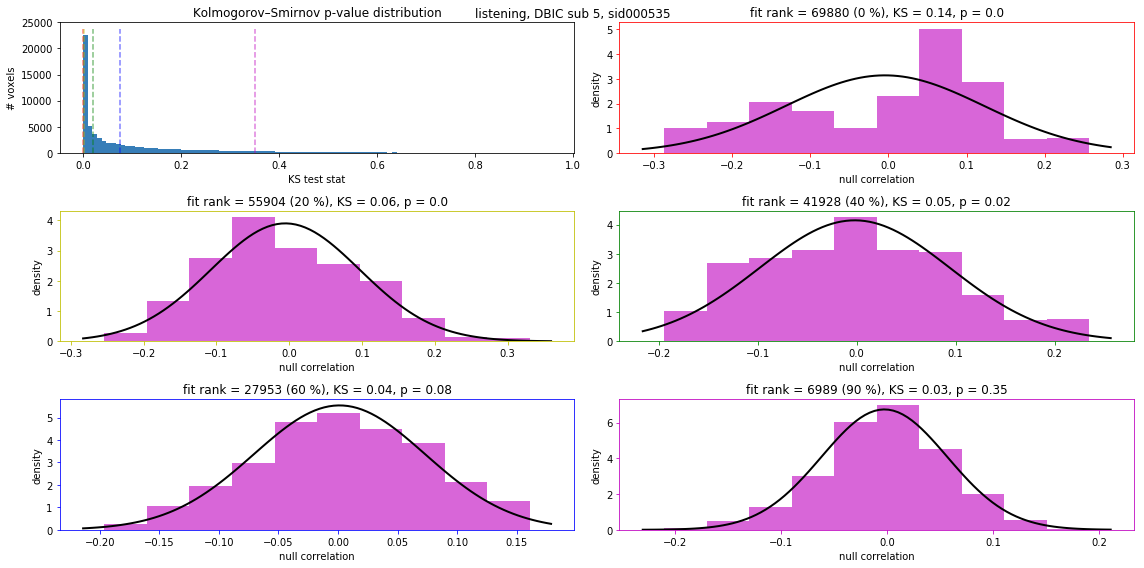

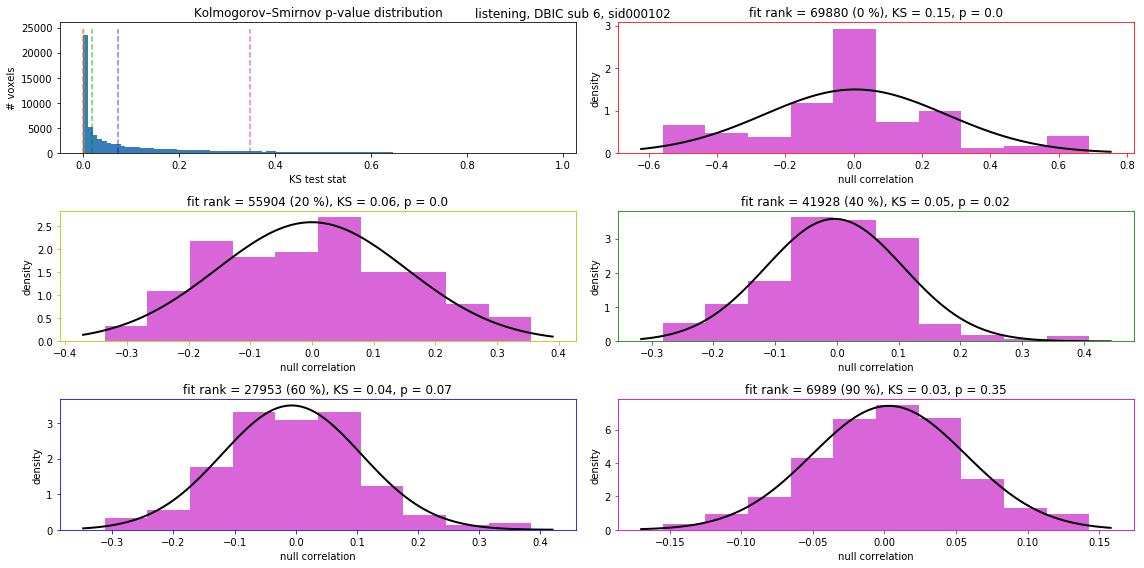

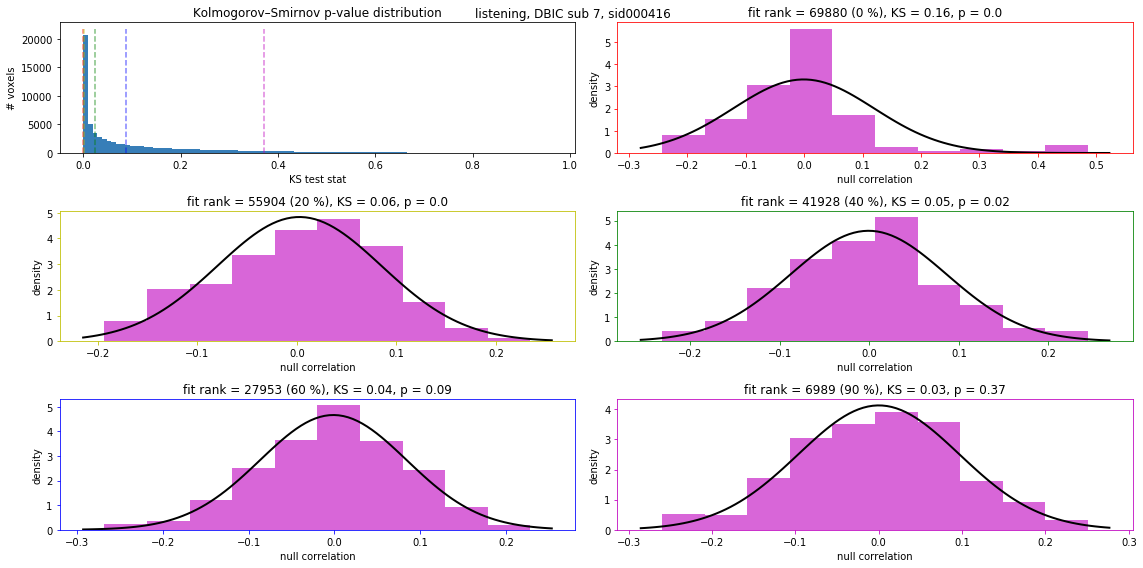

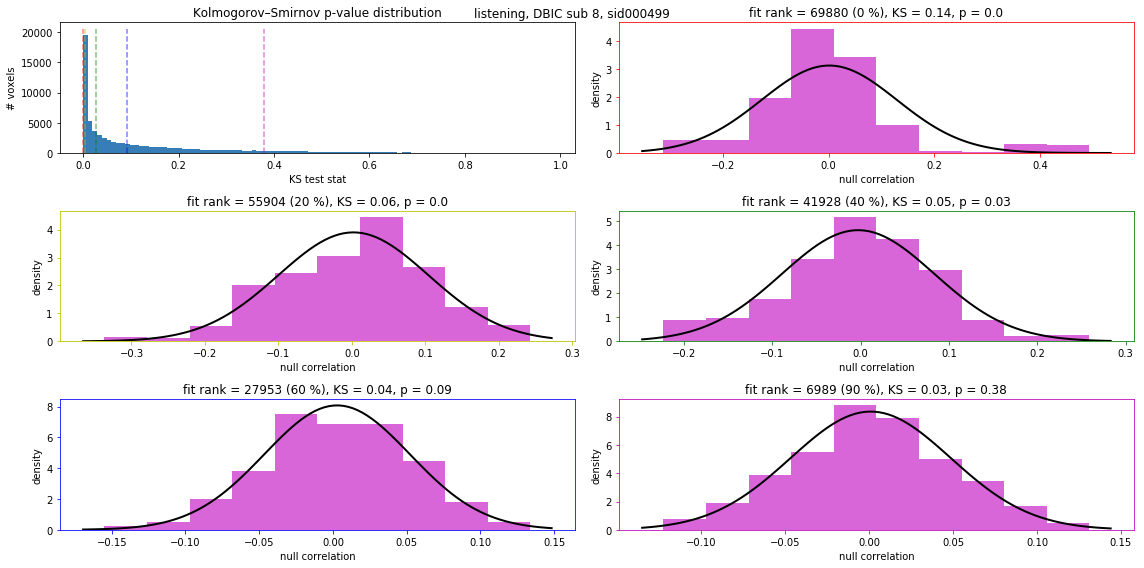

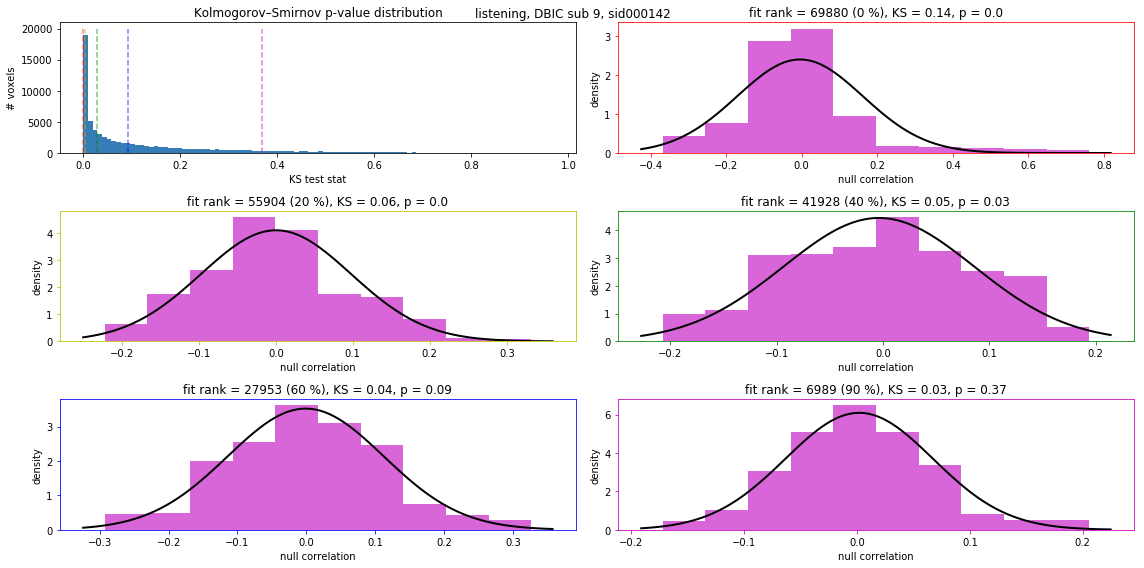

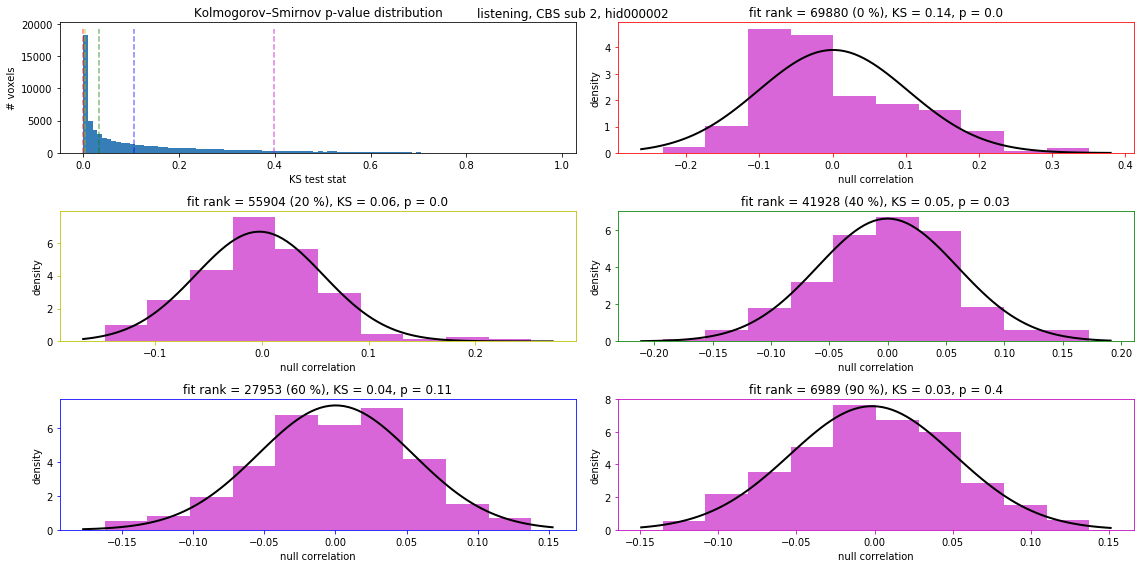

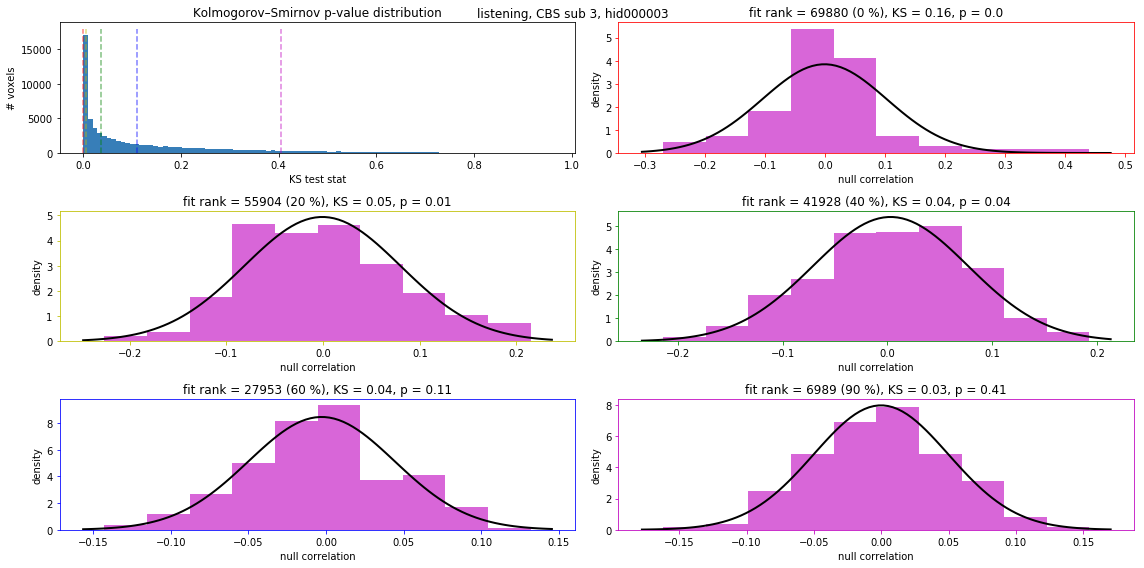

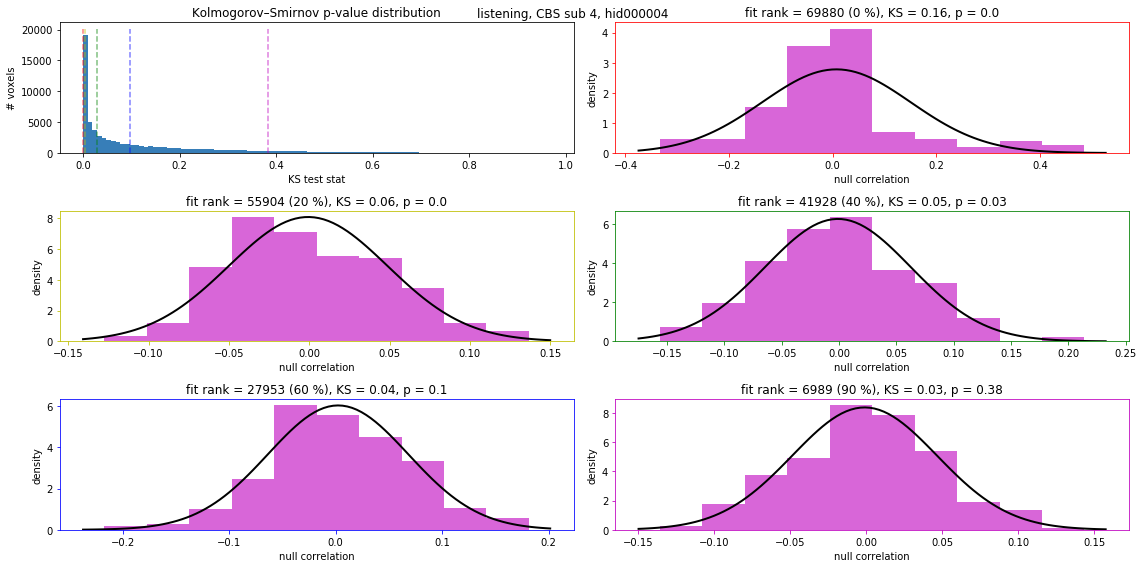

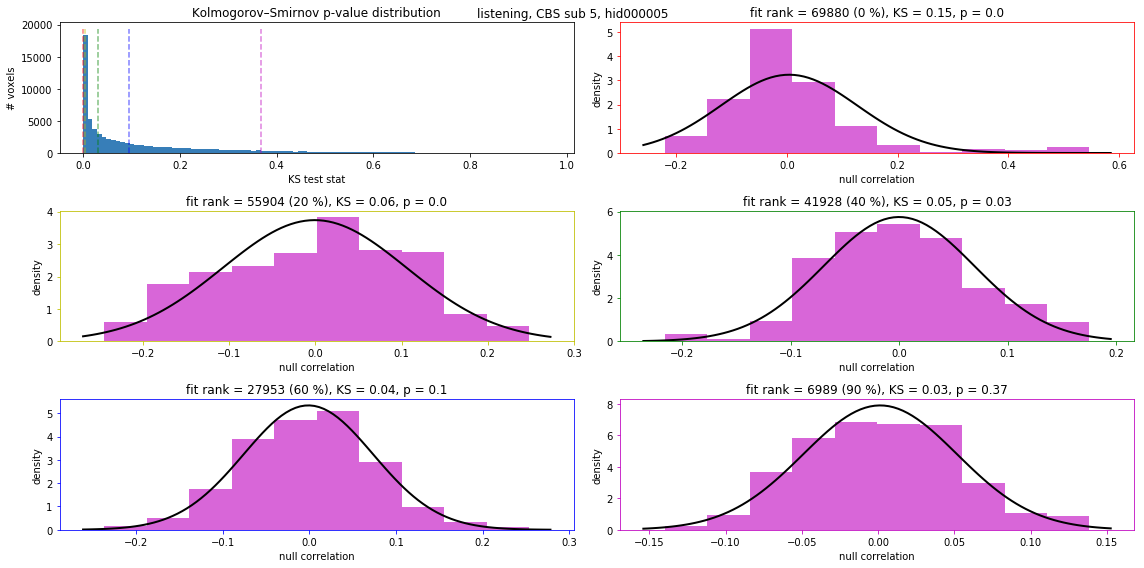

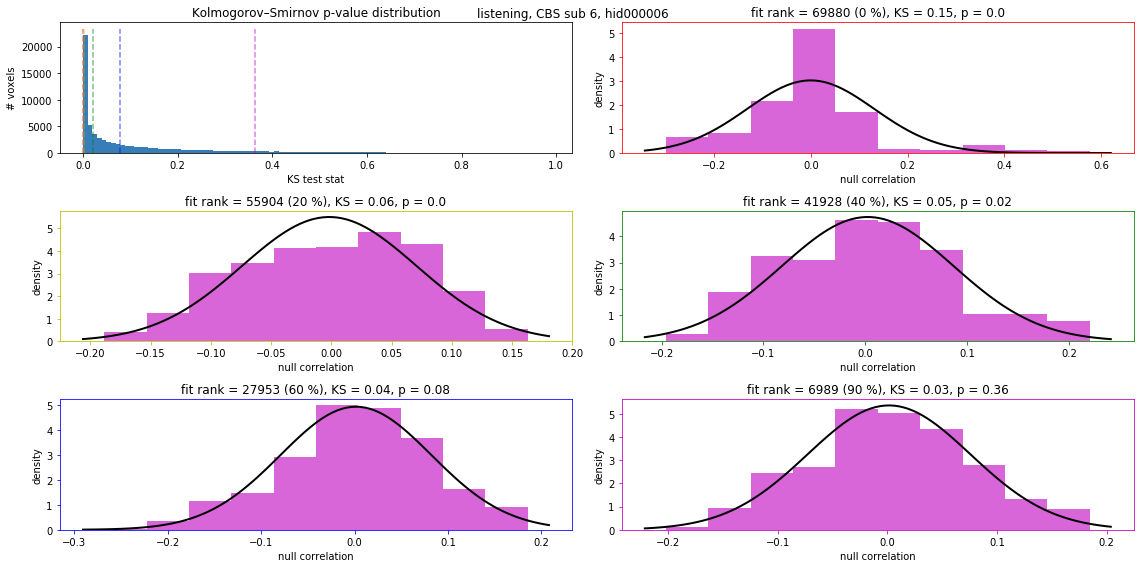

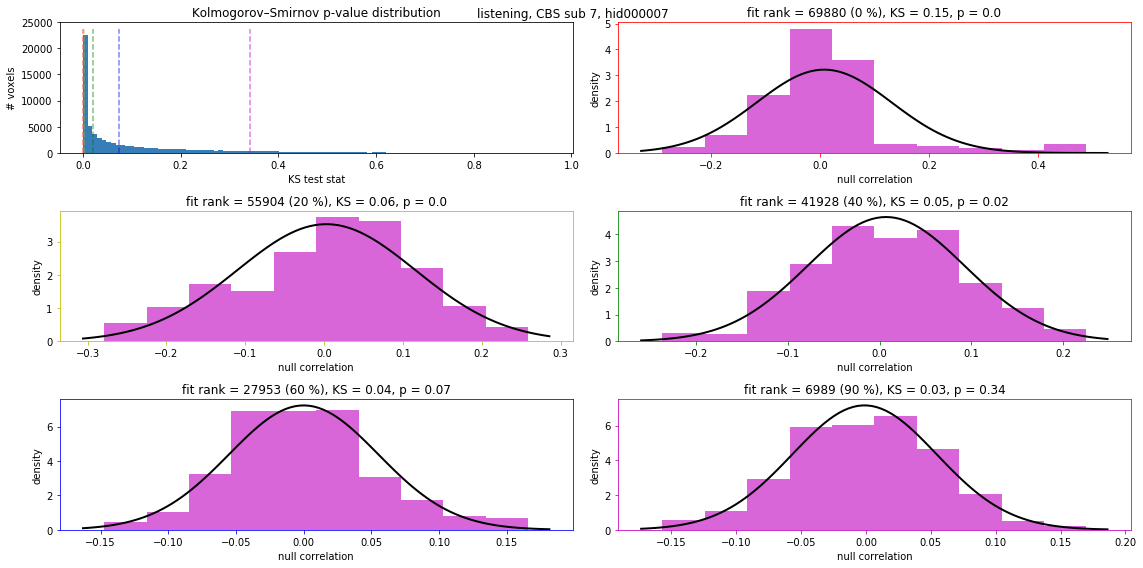

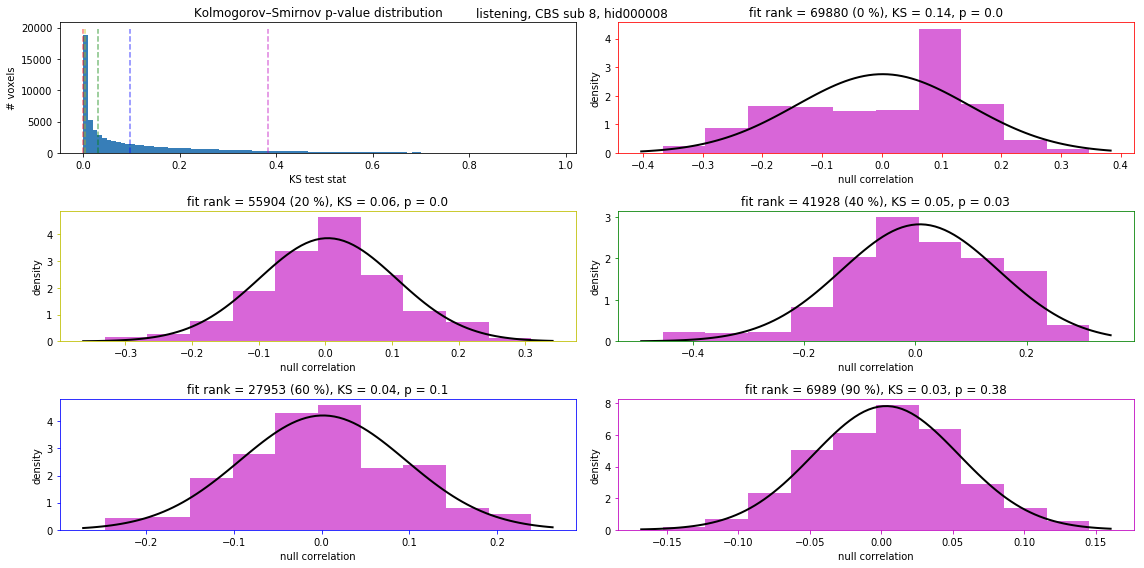

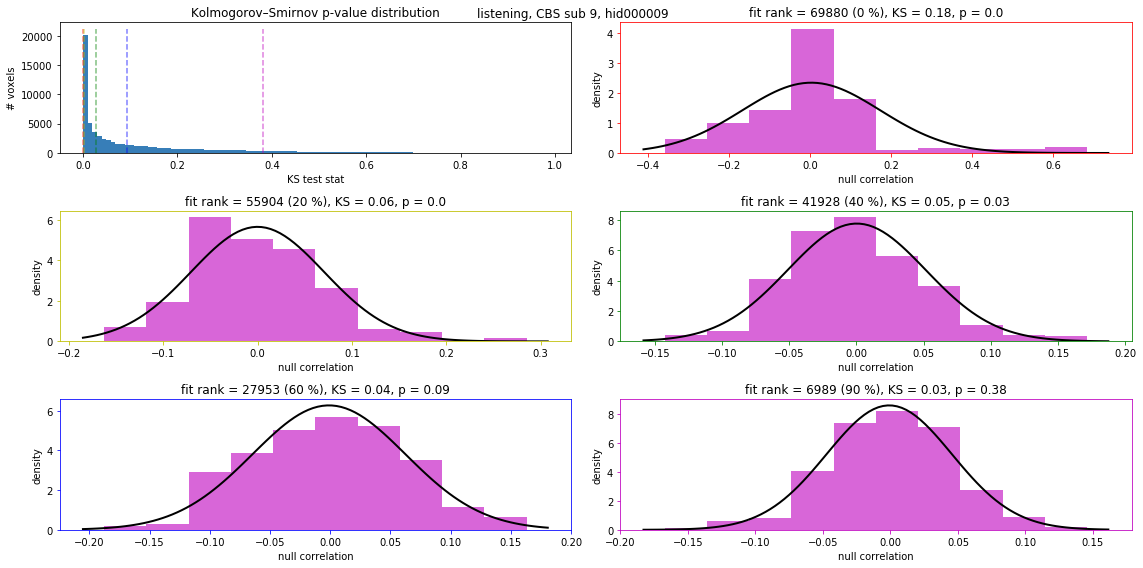

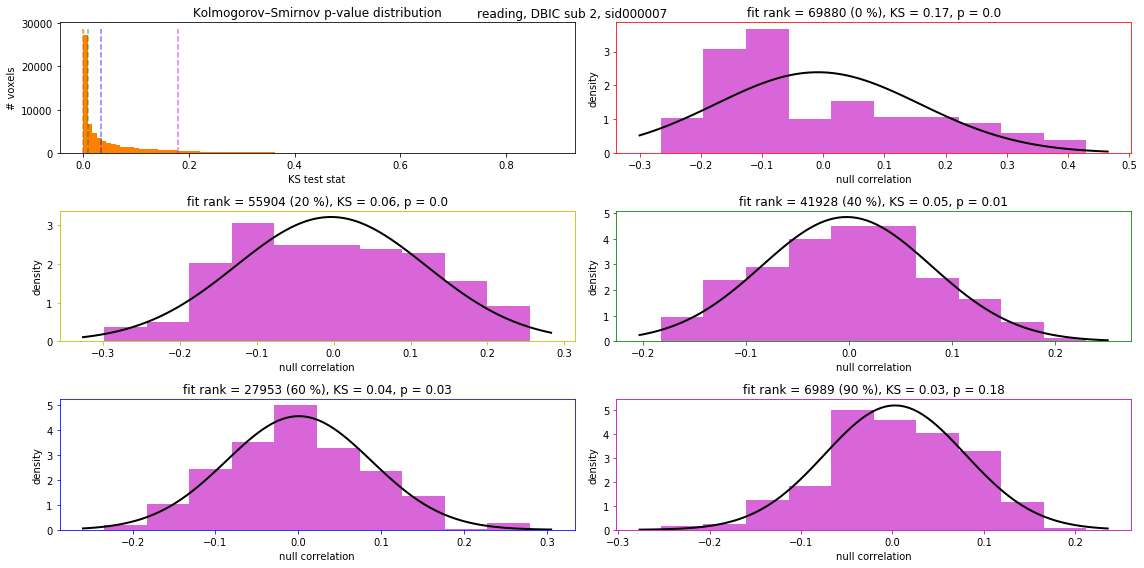

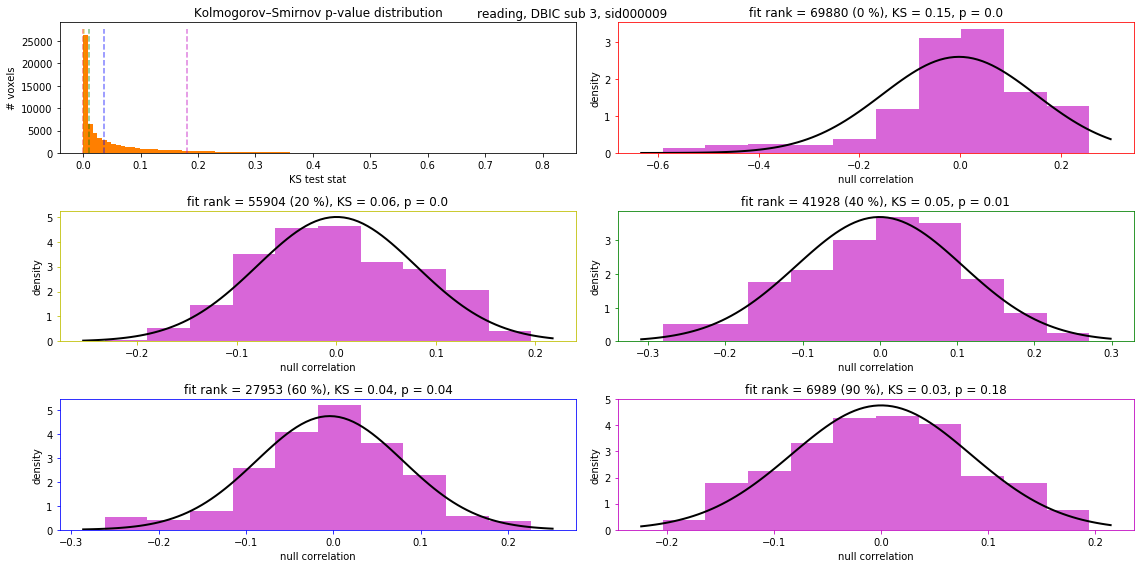

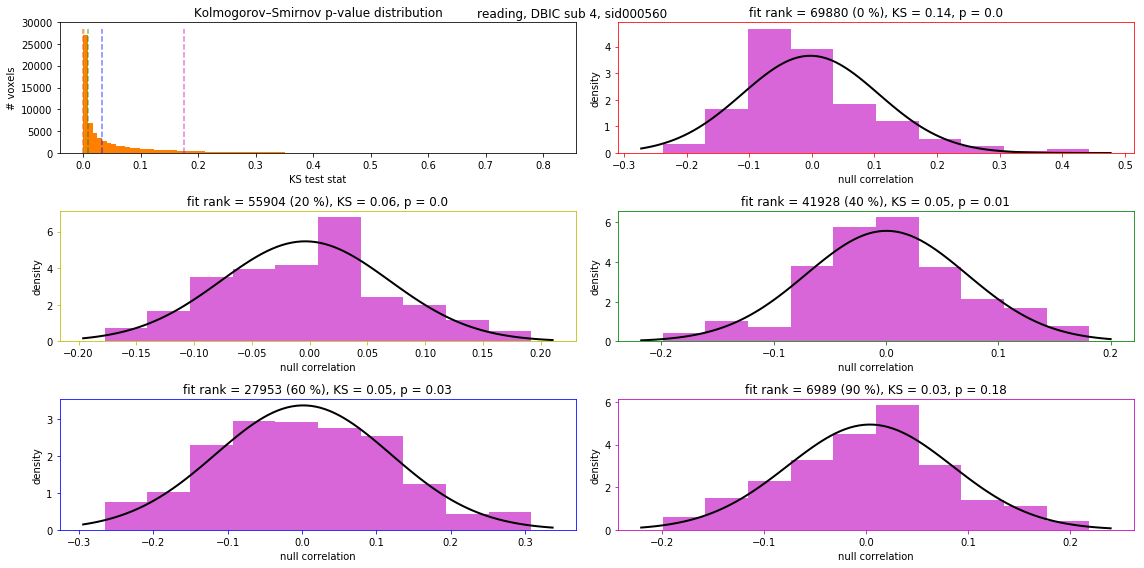

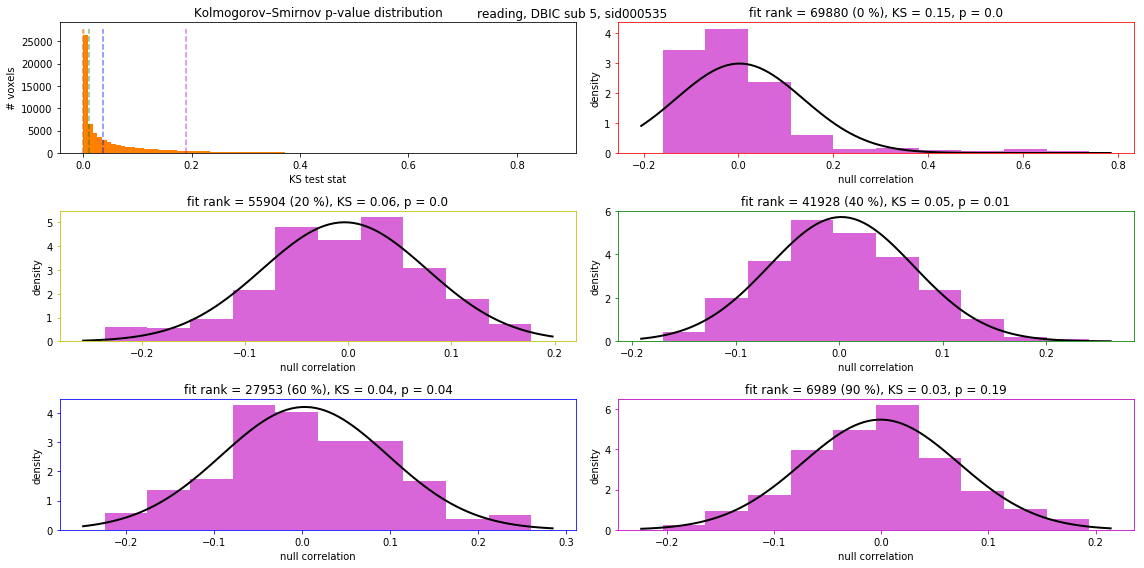

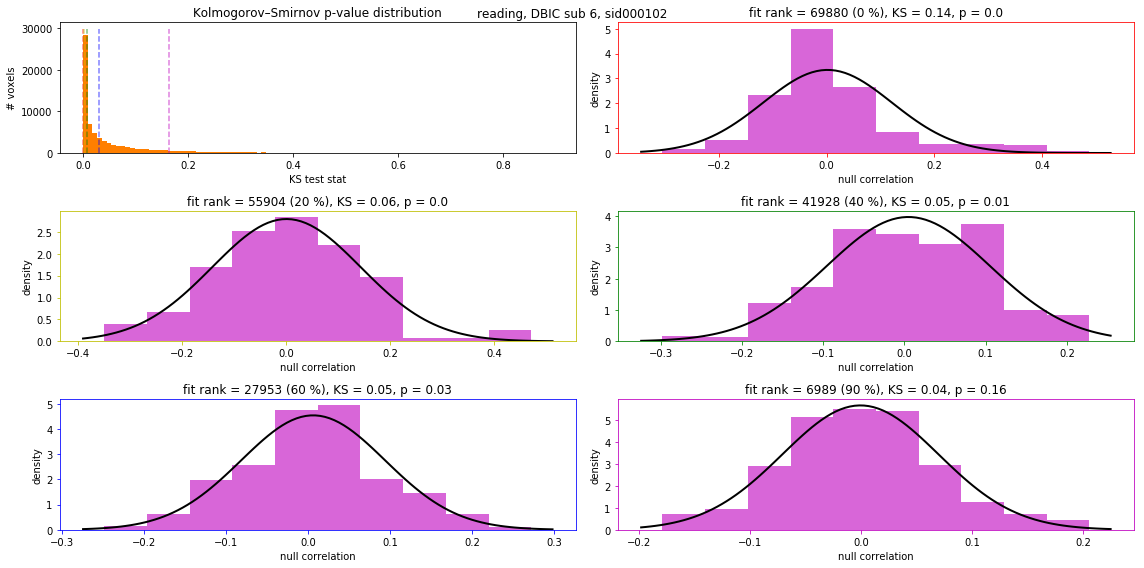

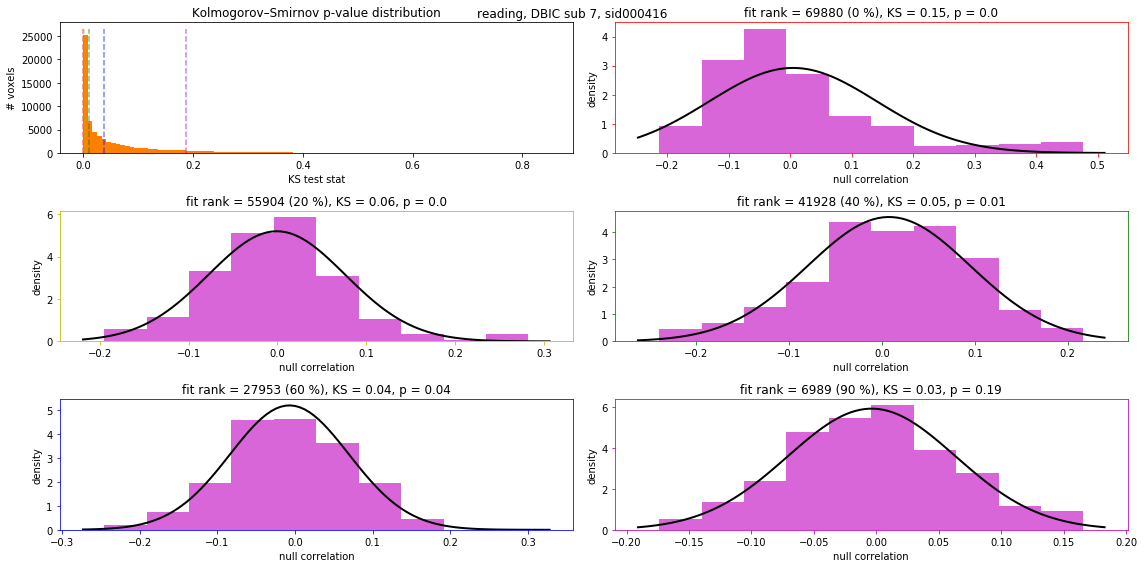

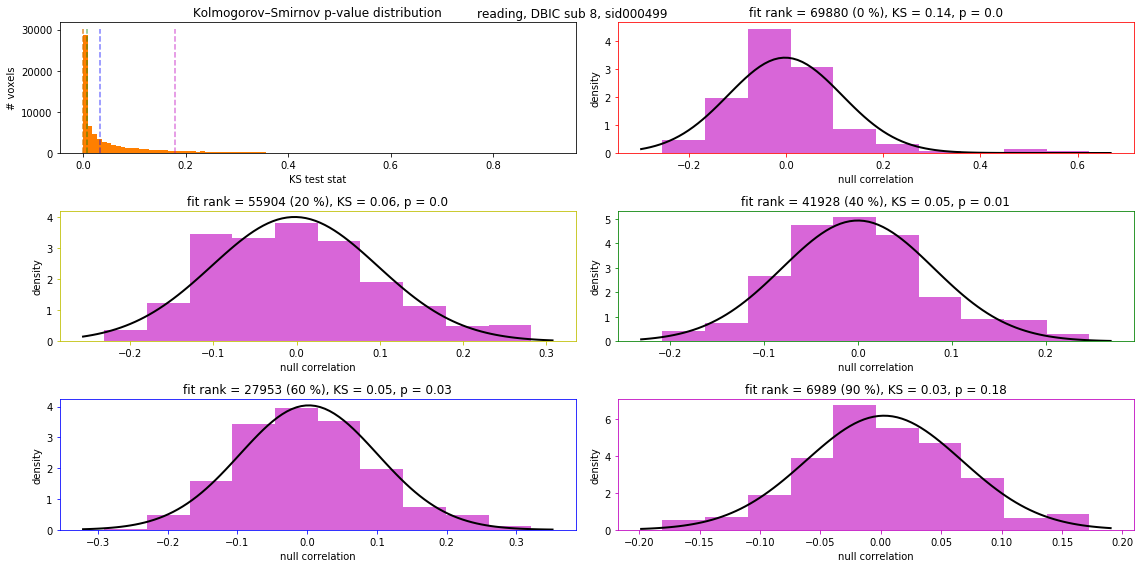

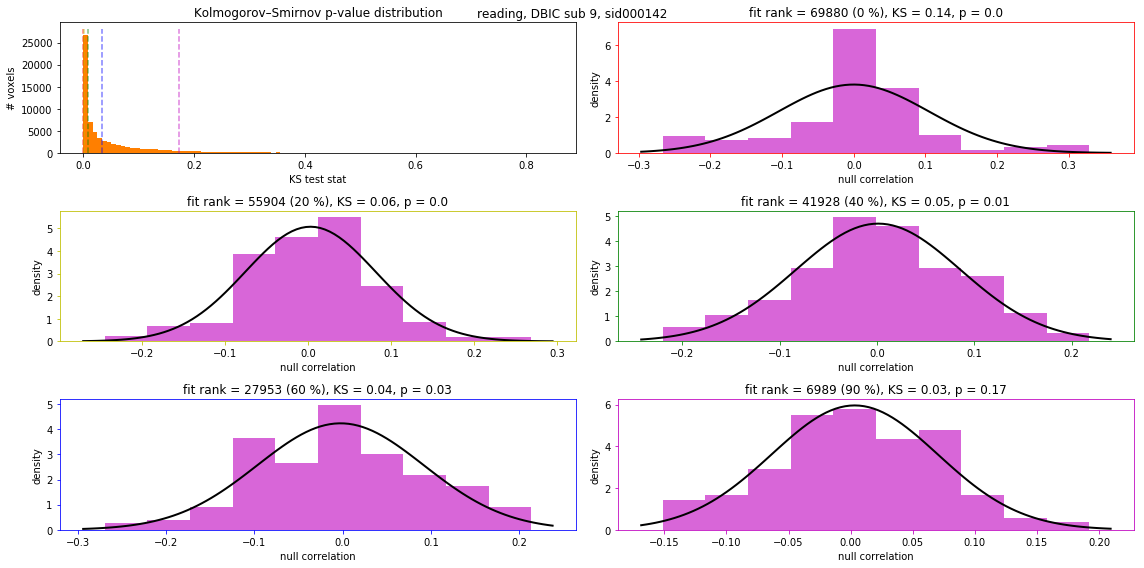

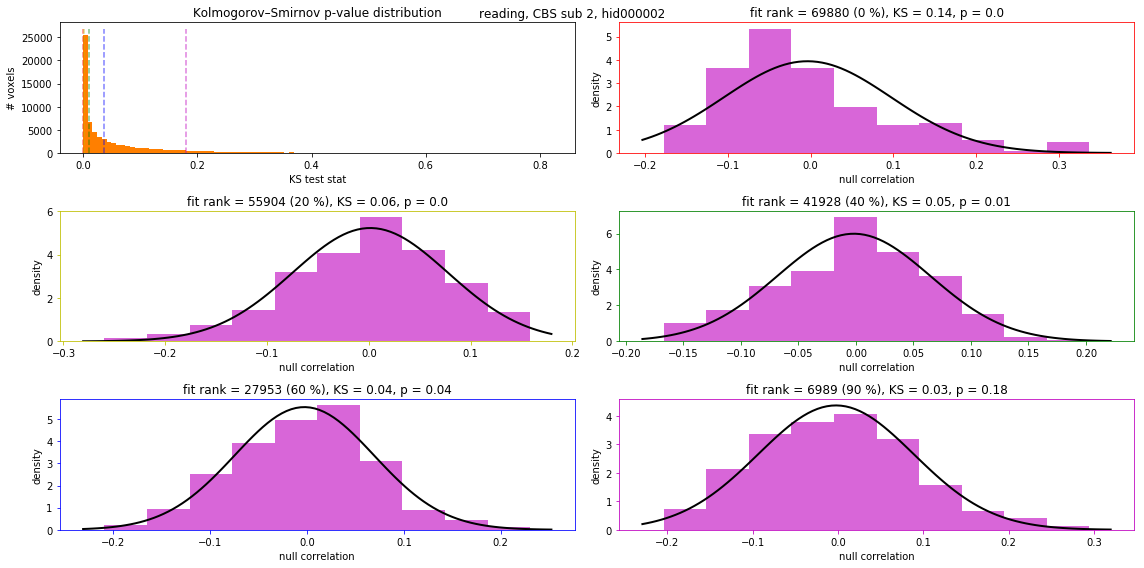

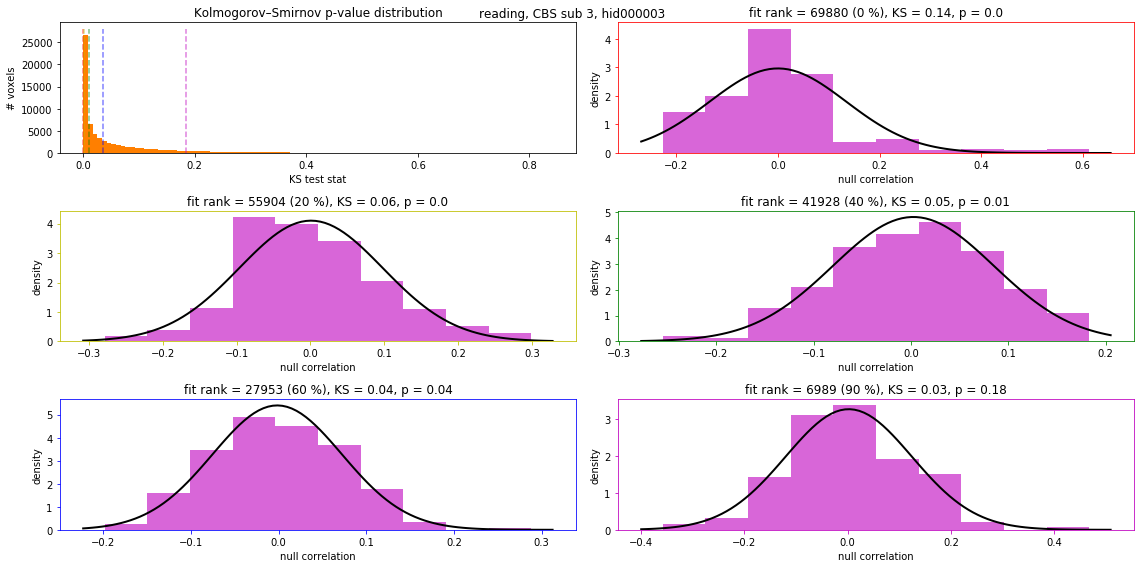

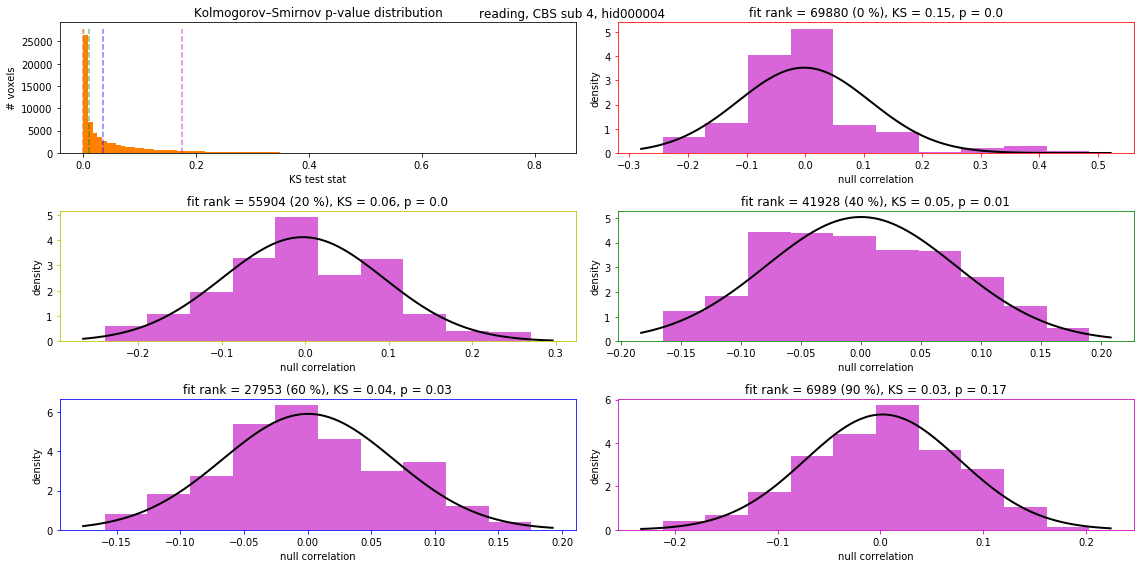

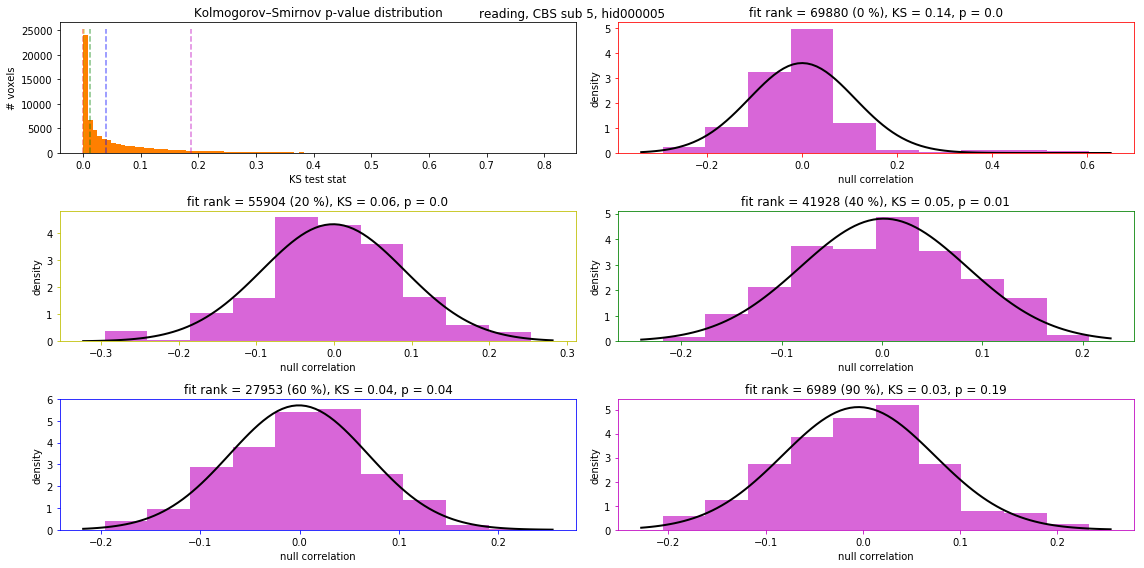

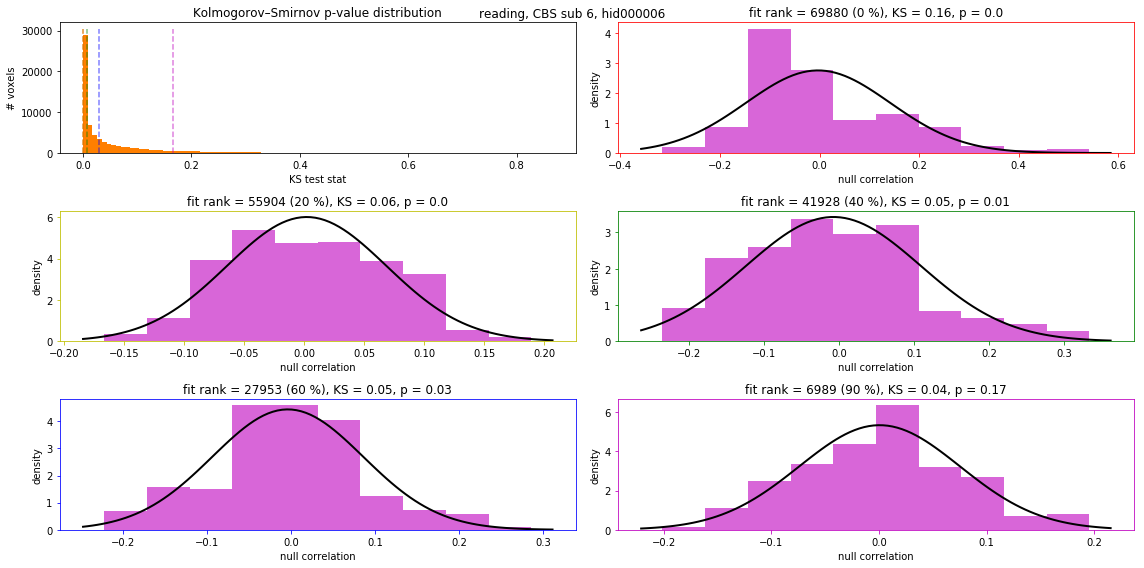

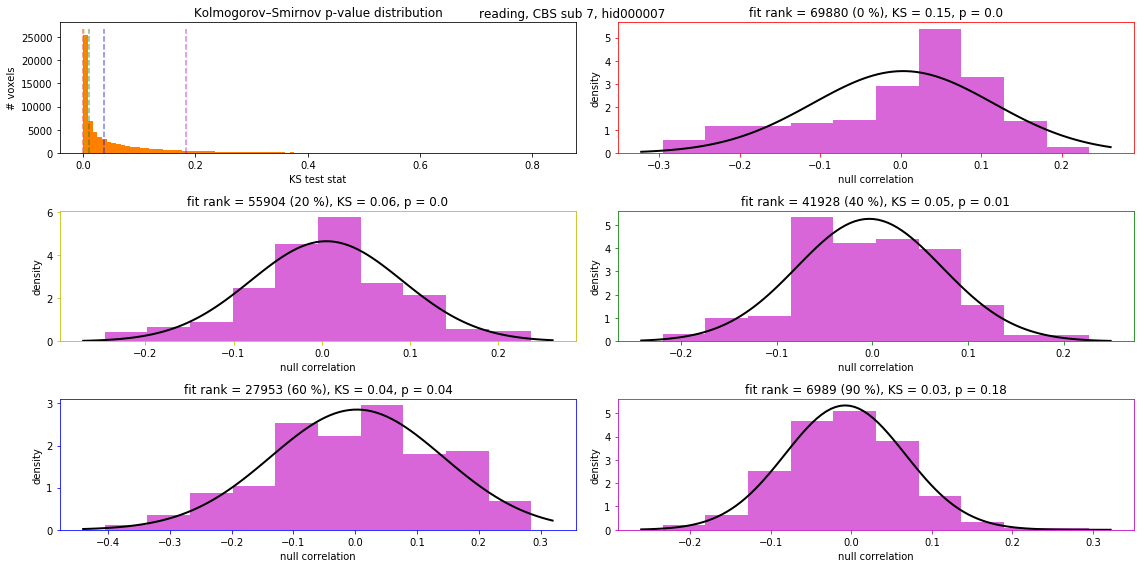

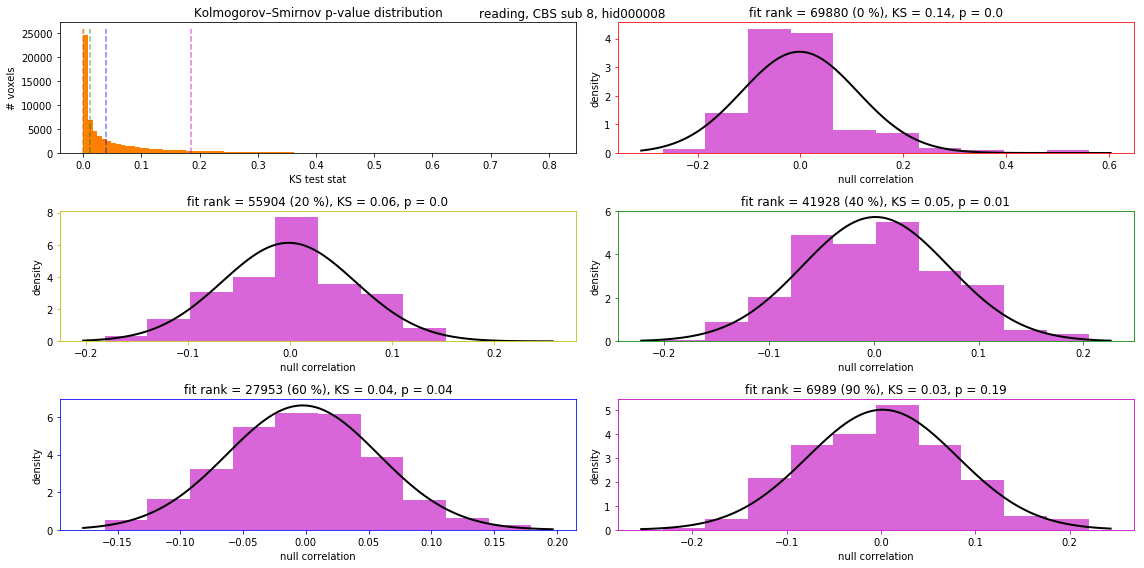

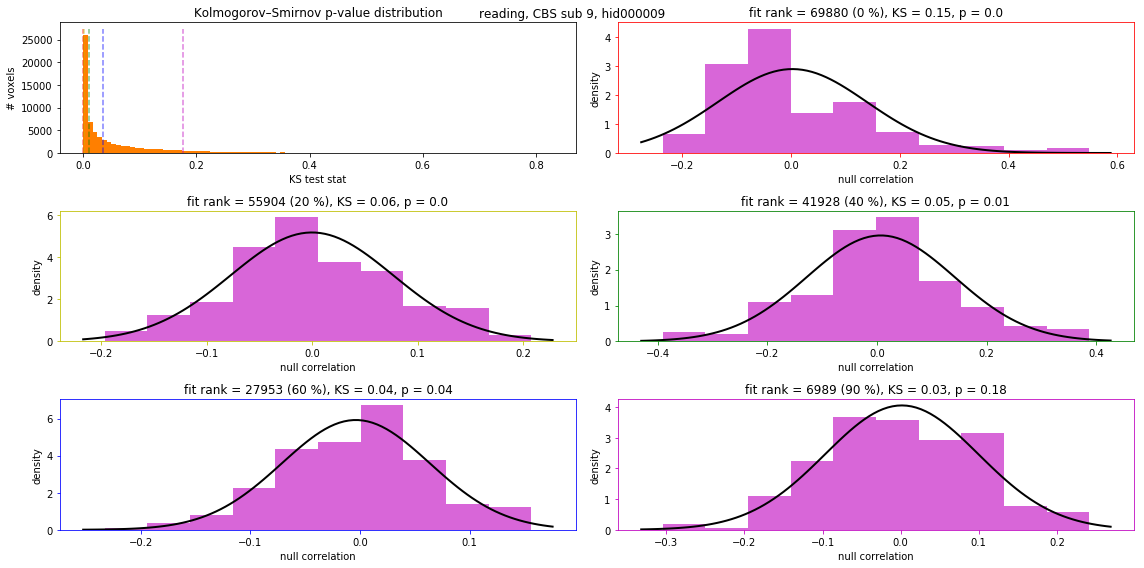

In [12]:
"""
For each subject, all voxels are sorted by their KS p-value. A histogram
of these is plotted, and then the user can select 5 percentiles of the sorted
voxels, with 0% corresponding to the voxel with the lowest p-value, 5%
corresponding to the voxel closest to the 5th percentile cutoff, etc...
The null distribution for these voxels are plotted in separate sub plots
with the fitted normal distributions overlaid.
"""

# define function that extracts an element of an array closest to a given percentile within that array
def find_nearest_percentile_index(array, percentile):
    """
    :param array:
    :param percentile:
    :return:
    """
    array = np.asarray(array)
    target = np.percentile(array, percentile)
    idx = (np.abs(array - target)).argmin()
    return idx

# set subplotting map
spMap = np.arange(6).reshape(3,2) + 1

# colorblind-friendly colors list
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

# set task colors
taskColors = CB_color_cycle[:2]

# set desired fit percentiles
fitPercentiles = [0, 20, 40, 60, 90]

# set percentile voxel colors
voxColors = ['r','y','g','b','m']

for TASK in [0,1]:

    for SUB in range(numSubs):

        # initialize plot
        plt.figure(facecolor='white',figsize=(16,8))

        # main title
        plt.suptitle(taskNames[TASK] + ', ' + subList['site'][SUB] + ' sub ' + str(subList['pairNum'][SUB]) + ', ' + subList['subID'][SUB])

        # convert KS test statistic values to numpy array
        KSval = np.empty([numVox, 1])
        for VOX in range(len(permTest[TASK][SUB][4])):
            KSval[VOX] = permTest[TASK][SUB][4][VOX][1]

        # get sorted KS statistic values lower than alpha
        KSval_i = np.argsort(KSval[:,0])
        KSval = KSval[KSval_i]

        # select subplot for histogram
        plt.subplot(spMap.shape[0], spMap.shape[1], 1)

        # plot KS statistic histogram
        plt.hist(KSval, bins=100, density=False, alpha=1, color=taskColors[TASK])
        plt.xlabel('KS test stat')
        plt.ylabel('# voxels')
        plt.title('Kolmogorov–Smirnov p-value distribution')

        # get voxel indices for various fit percentiles
        evox = [[]] * len(fitPercentiles) # preallocate voxel index list
        counter = 0 # initialize counter
        for PERC in fitPercentiles:
            evox[counter] = find_nearest_percentile_index(KSval, PERC)
            counter += 1

        # get histogram max y-value
        yMax = plt.gca().get_ylim()[1]

        # plot single voxel timeseries
        for VOX in range(len(fitPercentiles)):

            # add vertical bars to histogram
            plt.subplot(spMap.shape[0], spMap.shape[1], 1)
            xVal = KSval[evox[VOX],0]
            plt.plot([xVal, xVal], [0, yMax], '--', color=voxColors[VOX], alpha=0.5)

            # select subplot for time series line plot
            ax = plt.subplot(spMap.shape[0], spMap.shape[1], VOX + 2)
            plt.setp(ax.spines.values(), color=voxColors[VOX])
            plt.setp([ax.get_xticklines(), ax.get_yticklines()], color=voxColors[VOX])

            # Generate some data for this demonstration.
            nullData = nullCorr[TASK][SUB][:,KSval_i[evox[VOX]]]

            # Plot the histogram.
            plt.hist(nullData, density=True, alpha=0.6, color='m')

            # Plot the PDF
            xmin, xmax = plt.xlim() # get plot x-limits
            x = np.linspace(xmin, xmax, 100) # set x values over which to define the PDF to cover the domain of the histogram
            mu = permTest[TASK][SUB][3][KSval_i[evox[VOX]]][0] # get mean from fitting during permutation test
            std = permTest[TASK][SUB][3][KSval_i[evox[VOX]]][1] # get SD from fitting during permutation test
            p = norm.pdf(x, mu, std) # get PDF y values
            plt.plot(x, p, 'k', linewidth=2)
            ksStat = round(permTest[TASK][SUB][4][KSval_i[evox[VOX]]][0] * 100) / 100
            ksPval = round(permTest[TASK][SUB][4][KSval_i[evox[VOX]]][1] * 100) / 100

            # subplot title and axis labels
            plt.title("fit rank = " + str(numVox - evox[VOX]) + " (" + str(fitPercentiles[VOX]) + " %), KS = " + str(ksStat) + ", p = " + str(ksPval))
            plt.xlabel('null correlation')
            plt.ylabel('density')

        plt.tight_layout()
        plt.show()


